# 10장(마지막). 설문조사 데이터에서 정보 추출하기
**문장(문자열)으로부터 필요한 정보를 추출하고, 추출한 정보로부터 특징량을 계산해 수치화하는 '자연어 처리'**를 배운다.  
이 자연어 처리는 데이터 분석을 위해 수치화하는 과정이다.  

---
의뢰한 고객은 부동산업을 경영하는 사업가이다. 고객들에게 받은 설문조사 결과를 눈으로 훑어보기에 양이 너무 많아, AI를 활용하여 분석해보려고 한다.  
그래서 사람들로부터 받은 설문조사에서 유용한 정보만 뽑아보려 하는 게 오늘 분석의 목적!

## Tech 91. 데이터를 불러오자
데이터는 2019년 1월~4월 간 모은 고객만족도 설문조사 데이터이다.

In [1]:
import pandas as pd
sur = pd.read_csv('10장/survey.csv')
print(sur.shape)
display(sur.head())

(86, 3)


,datetime,comment,satisfaction
0,2019-03-11,역앞에 젊은이들이 모여있다(AA역),1
1,2019-02-25,운동할 수 있는 장소가 있는 것이 좋다,5
2,2019-02-18,육아 지원이 좋다,5
3,2019-04-09,어린이집에 바로 입원할 수 있다(대기아동 없음),4
4,2019-01-06,역앞 상가가 쓸쓸하다,2


In [2]:
#결측치 확인
sur.isna().sum()

datetime        0
comment         2
satisfaction    0
dtype: int64

In [3]:
#사실 설문조사에서는 의견(comment)가 비어있는 경우가 많다. 만족도는 쉬우니까 그냥 체크하지만,,,
#이 데이터에선 딱 2개밖에 결측치가 없으므로 제거
sur = sur.dropna(how='any')
sur.isna().sum()

datetime        0
comment         0
satisfaction    0
dtype: int64

## Tech 92. 불필요한 문자를 제거하자
사람들마다 언어를 쓰는 방식이 다르다. 특히 대표적인 것이 누구는 공백이 없고 누구는 공백이 1개,  2개 그 이상이다.  
괄호도 붙일때도 있고 안붙이는 경우도 있고..  
그래서 여기서는 괄호를 비롯한 불필요한 특수문자를 제거해보자! (정규 표현식 활용)

In [4]:
sur.head()

,datetime,comment,satisfaction
0,2019-03-11,역앞에 젊은이들이 모여있다(AA역),1
1,2019-02-25,운동할 수 있는 장소가 있는 것이 좋다,5
2,2019-02-18,육아 지원이 좋다,5
3,2019-04-09,어린이집에 바로 입원할 수 있다(대기아동 없음),4
4,2019-01-06,역앞 상가가 쓸쓸하다,2


In [5]:
# 'AA역'에서 AA를 지워보자.
sur['comment'] = sur['comment'].str.replace('AA','')
sur.head()

,datetime,comment,satisfaction
0,2019-03-11,역앞에 젊은이들이 모여있다(역),1
1,2019-02-25,운동할 수 있는 장소가 있는 것이 좋다,5
2,2019-02-18,육아 지원이 좋다,5
3,2019-04-09,어린이집에 바로 입원할 수 있다(대기아동 없음),4
4,2019-01-06,역앞 상가가 쓸쓸하다,2


In [6]:
#위의 결과를 보면 (역) 이라거나 (대기아동 없음) 처럼 괄호를 쓴 경우가 있다.
#보통 이렇게 괄호가 있다면, 괄호와 괄호 안의 내용을 제거한다.
sur['comment'] = sur['comment'].str.replace('\(.+?\)', '') #( ) 괄호 안에 1문자 이상 있으면 제거 
sur.head()

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,datetime,comment,satisfaction
0,2019-03-11,역앞에 젊은이들이 모여있다,1
1,2019-02-25,운동할 수 있는 장소가 있는 것이 좋다,5
2,2019-02-18,육아 지원이 좋다,5
3,2019-04-09,어린이집에 바로 입원할 수 있다,4
4,2019-01-06,역앞 상가가 쓸쓸하다,2


## Tech 93. 문자 수를 히스토그램으로 나타내자
이젠 각 의견(comment)의 문자수를 세어보자. 장문도 있고, 단문도 있다.

In [7]:
len(sur['comment'][0])

14

In [8]:
sur['comment'].str.len()

0     14
1     21
2      9
3     17
4     11
      ..
81    22
82    26
83    15
84    14
85    17
Name: comment, Length: 84, dtype: int64

In [9]:
#새로운 열 'length' 생성
sur['length'] = sur['comment'].str.len()
sur.head()

,datetime,comment,satisfaction,length
0,2019-03-11,역앞에 젊은이들이 모여있다,1,14
1,2019-02-25,운동할 수 있는 장소가 있는 것이 좋다,5,21
2,2019-02-18,육아 지원이 좋다,5,9
3,2019-04-09,어린이집에 바로 입원할 수 있다,4,17
4,2019-01-06,역앞 상가가 쓸쓸하다,2,11


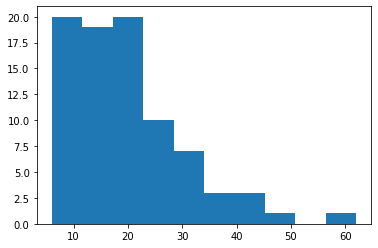

In [10]:
#이제 length 열을 히스토그램으로!
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(sur['length'])
plt.show()

## Tech 94. 형태소 분석: 문장 분해하기 (konlpy)
위에서 의견의 글자수를 보면 10~20자가 가장 많다. 비교적 간단하게 단문으로 쓴 의견이 가장 많다.  

- 형태소 분석: 문장을 단어로 분할하는 기술.
- 대표적인 형태소 분석 라이브러리는 `konlpy`가 있다. 이걸 다운받아보자 (난 이미 다운이 되어있었당)

In [11]:
#예제: text라는 문장을 품사 단위로 분해하기 
from konlpy.tag import Twitter
twt = Twitter()
text = '형태소분석으로 문장을 분해해보자'
tagging = twt.pos(text)
tagging #단어와 품사가 리스트 형태로 표시됨 

C:\Users\user\anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


[('형태소', 'Noun'),
 ('분석', 'Noun'),
 ('으로', 'Josa'),
 ('문장', 'Noun'),
 ('을', 'Josa'),
 ('분해', 'Noun'),
 ('해보자', 'Verb')]

In [12]:
#위의 결과에서 단어만 따로 리스트에 저장해보자.
sy = []
for i, j in tagging:
    sy.append(i)
    
sy

['형태소', '분석', '으로', '문장', '을', '분해', '해보자']

In [13]:
#책에 나온대로..
sy = []
for i in tagging:
    #if i == 'EOS' : continue
    sy.append(i[0])
        
sy

['형태소', '분석', '으로', '문장', '을', '분해', '해보자']

나는 tagging이 튜플 형태로 (단어, 품사) 로 되어 있어서 이를 (i, j)로 두고 i만 리스트에 append시켰다.  
책에서는 i, j로 나누지 않고 그냥 i로 둔것! 그리고 i[0]이 단어, i[1]이 품사라 i[0]만 리스트에 append시킨 것임!  
(EOS는 문장의 끝 이라는 뜻이라는데,, 왜쓴건진 잘 몰겠다 주석처리해도 실행이 잘돼서,,)

## Tech 95. 형태소 분석으로 문장에서 '동사', '명사'만 추출하기
위에서 pos 태깅을 활용해 품사를 뽑을수 있음을 배웠다.  
이를 이용해, 품사가 '동사', '명사'인 애들만 뽑아보자.

In [14]:
text = '형태소분석으로 문장을 분해해보자'
tagging = twt.pos(text)
tagging

[('형태소', 'Noun'),
 ('분석', 'Noun'),
 ('으로', 'Josa'),
 ('문장', 'Noun'),
 ('을', 'Josa'),
 ('분해', 'Noun'),
 ('해보자', 'Verb')]

In [15]:
sy = []
for i, j in tagging:
    if j == 'Noun' or j == 'Verb':
        sy.append(i)
        
sy

['형태소', '분석', '문장', '분해', '해보자']

In [16]:
#위처럼 간단쓰하게 만들수 있음. 하지만 책에 나온대로 해보자
#품사가 명사/동사가 아닌 경우 continue에 의해 words_arr 에 저장되지 않음.

words_arr = []
parts = ['Noun', 'Verb']

for i in tagging:
    if i == 'EOS' or i == ' ' : continue
    word_temp = i[0] #word
    part = i[1] #품사
    if not (part in parts): continue 
    words_arr.append(word_temp)
    
words_arr

['형태소', '분석', '문장', '분해', '해보자']

## Tech 96. 형태소 분석으로 자주 나오는 '명사'가 무엇인지 알아보자
여기서는 `설문 결과에서 어떤 단어가 사용됐을 때 만족도가 높은지` 를 살펴볼 것이다.  
우선은 전체 comment 에서 '명사' 만 전부 다 뽑아보자.

In [17]:
sur.head()

,datetime,comment,satisfaction,length
0,2019-03-11,역앞에 젊은이들이 모여있다,1,14
1,2019-02-25,운동할 수 있는 장소가 있는 것이 좋다,5,21
2,2019-02-18,육아 지원이 좋다,5,9
3,2019-04-09,어린이집에 바로 입원할 수 있다,4,17
4,2019-01-06,역앞 상가가 쓸쓸하다,2,11


In [18]:
all_word = [] #이 리스트에 명사를 담을 예정

for n in range(len(sur)):
    text = sur['comment'].iloc[n]
    words = twt.pos(text)
    
    for i, j in words:
        if j == 'Noun':
            all_word.append(i)
            
print(all_word)

['역앞', '젊은이', '운동', '수', '장소', '것', '육아', '지원이', '어린이집', '바로', '입원', '수', '역앞', '상가', '생활', '놀', '장소', '놀', '장소', '상업시설', '좀', '더', '병원', '사이클링', '코스', '축제', '좀', '더', '성대', '초등학교', '공원', '더', '근처', '공원', '살기', '슈퍼', '육아', '데이트', '명소', '상가', '좀', '더', '밤길', '쓰레기', '처리', '영화관', '가로수', '더', '공원', '추가', '관광', '명소', '육아', '최고', '길이', '시내', '접근성', '집세', '합리', '의', '교통', '체증', '게', '해', '상가', '지붕', '비', '큰일', '상가', '더', '카페', '스포츠', '센터', '자주', '이용', '스포츠', '센터', '이용', '요금', '워킹맘', '지원', '더', '버스', '별로', '안', '자전거', '달리기', '달리기', '운동', '수', '장소', '기업', '역앞', '주차장', '아저씨', '말', '적', '경찰', '순찰', '더', '소방', '활동', '수', '재난', '시', '피난', '장소', '것', '요즘', '강', '범람', '피해', '크게', '이', '도시', '범람', '방지', '취하', '설명', '신호등', '사거리', '때문', '사고', '신호', '상가', '활성화', '활동', '좀더', '행정', '뒷받침', '아이', '놀', '장소', '역앞', '자전거', '주차장', '가로수', '낙엽', '청소', '가로수', '재해', '시', '비축', '상황', '보도', '길이', '수', '지역', '자치', '단체', '더', '지원', '자치', '단체', '활동', '안심', '살', '수', '관광지', '최근', '지방', '넘버', '치안', '제대로', '주차장', '수가', '요금'

In [19]:
#추출된 단어들을 잘 살펴보면 중복되는 단어가 몇개 있다. '역앞' 같은것도 여러번 나오고,,
#그래서 단어의 빈도수를 집계해서, 자주 등장한 단어 Top 5만 뽑아보자!

all_word_df = pd.DataFrame(all_word, columns = ['words'])
all_word_df = pd.DataFrame(all_word_df.groupby('words')['words'].count())
all_word_df.rename(columns = {'words': 'cnt'}, inplace=True)
all_word_df.reset_index(inplace=True)
all_word_df

,words,cnt
0,가로수,3
1,강,1
2,거리,1
3,걱정,1
4,걸,1
...,...,...
182,확인,1
183,확장,1
184,활기,1
185,활동,3


In [20]:
all_word_df.sort_values(by = 'cnt', ascending=False)[:5]

,words,cnt
40,더,14
88,수,7
137,장소,6
149,주차장,5
147,좀,5


In [21]:
#책에서 나온대로 해도 됨!
all_word_df = pd.DataFrame({'words': all_word, 'count': len(all_word)*[1]}) #'count' 열에 모두 1 값 집어넣음 
all_word_df

,words,count
0,역앞,1
1,젊은이,1
2,운동,1
3,수,1
4,장소,1
...,...,...
278,놀이기구,1
279,공원,1
280,더,1
281,역앞,1


In [22]:
all_word_df = all_word_df.groupby('words').count()
all_word_df.sort_values('count', ascending=False).head()

,count
words,
더,14
수,7
장소,6
주차장,5
좀,5


## Tech 97. 관계없는 단어 제거하기
앞에서 '더', '수', '좀'이 많이 나온 명사 Top 5였는데, 사실상 불필요한 단어이다. 어떠한 의미도 찾을 수 없으니!!  
그래서 얘네를 stopwords 처리해서, 애초부터 명사를 뽑은 all_word 리스트에 안 들어가게 하자.

In [23]:
all_word = [] #이 리스트에 명사를 담을 예정
stop_words = ['더', '수', '좀']

for n in range(len(sur)):
    text = sur['comment'].iloc[n]
    words = twt.pos(text)
    
    for i, j in words:
        if j == 'Noun':
            if i not in stop_words: #stop_words 안의 단어라면 포함 안되게 하기 
                all_word.append(i)
            
print(all_word)

['역앞', '젊은이', '운동', '장소', '것', '육아', '지원이', '어린이집', '바로', '입원', '역앞', '상가', '생활', '놀', '장소', '놀', '장소', '상업시설', '병원', '사이클링', '코스', '축제', '성대', '초등학교', '공원', '근처', '공원', '살기', '슈퍼', '육아', '데이트', '명소', '상가', '밤길', '쓰레기', '처리', '영화관', '가로수', '공원', '추가', '관광', '명소', '육아', '최고', '길이', '시내', '접근성', '집세', '합리', '의', '교통', '체증', '게', '해', '상가', '지붕', '비', '큰일', '상가', '카페', '스포츠', '센터', '자주', '이용', '스포츠', '센터', '이용', '요금', '워킹맘', '지원', '버스', '별로', '안', '자전거', '달리기', '달리기', '운동', '장소', '기업', '역앞', '주차장', '아저씨', '말', '적', '경찰', '순찰', '소방', '활동', '재난', '시', '피난', '장소', '것', '요즘', '강', '범람', '피해', '크게', '이', '도시', '범람', '방지', '취하', '설명', '신호등', '사거리', '때문', '사고', '신호', '상가', '활성화', '활동', '좀더', '행정', '뒷받침', '아이', '놀', '장소', '역앞', '자전거', '주차장', '가로수', '낙엽', '청소', '가로수', '재해', '시', '비축', '상황', '보도', '길이', '지역', '자치', '단체', '지원', '자치', '단체', '활동', '안심', '살', '관광지', '최근', '지방', '넘버', '치안', '제대로', '주차장', '수가', '요금', '역', '앞', '공공', '주차장', '보행자', '용', '신호', '노인', '어린이', '생각', '설정', '급행', '시내', '버스', '노선'

In [24]:
#이제 다시 all_word_df를 만들어서 바뀌었는지 살펴보자!
all_word_df = pd.DataFrame({'words': all_word, 'count': len(all_word)*[1]})
all_word_df = all_word_df.groupby('words').count()
all_word_df.sort_values('count', ascending=False).head()

,count
words,
장소,6
주차장,5
상가,5
역앞,5
공원,5


이렇게 stopwords 처리를 해서 불필요한 단어를 삭제하니 이전과는 다른 단어들이 많이 등장함을 알아볼 수 있다.  
여기서 '역앞'이 많이 나왔는데, 이게 긍정적인 내용일까?  
-> 자주 나오는 단어와 고객만족도 간의 관계를 살펴보자.

## Tech 98. 고객만족도와 자주 나오는 단어 간 관계를 살펴보자.

In [25]:
sur.head()

,datetime,comment,satisfaction,length
0,2019-03-11,역앞에 젊은이들이 모여있다,1,14
1,2019-02-25,운동할 수 있는 장소가 있는 것이 좋다,5,21
2,2019-02-18,육아 지원이 좋다,5,9
3,2019-04-09,어린이집에 바로 입원할 수 있다,4,17
4,2019-01-06,역앞 상가가 쓸쓸하다,2,11


In [26]:
#어렵지 않다! 아까 썼던 코드를 살짝만 변형해서, 해당 단어의 행일 때의 satisfaction을 리스트에 담자.
all_word = [] 
stop_words = ['더', '수', '좀']
satis = []

for n in range(len(sur)):
    text = sur['comment'].iloc[n]
    words = twt.pos(text)
    
    for i, j in words:
        if j == 'Noun':
            if i not in stop_words: #stop_words 안의 단어라면 포함 안되게 하기 
                all_word.append(i)
                satis.append(sur['satisfaction'].iloc[n])
            
# print(all_word)
# print(satis)

In [27]:
#이제 2개 리스트를 묶어 데이터프레임으로 만든다!
newdf = pd.DataFrame({'words': all_word, 'satis': satis, 'count': len(all_word)*[1]})
newdf.head()

,words,satis,count
0,역앞,1,1
1,젊은이,1,1
2,운동,5,1
3,장소,5,1
4,것,5,1


In [28]:
#satis와 count 컬럼 값을 연산해주자.
## words별로, satis (만족도)의 평균, count (단어 등장 횟수) - 책이랑 다름,,

newdf = newdf.groupby('words').agg({'satis': ['mean'], 'count': ['count']})
newdf.head()

,satis,count
,mean,count
words,,
가로수,1.666667,3
강,3.000000,1
거리,5.000000,1
걱정,2.000000,1
걸,2.000000,1


In [29]:
#그룹바이를 2가지 컬럼에 대해 했기 때문에 멀티인덱스(multi-index)가 설정되어 있음에 주의
newdf.columns

MultiIndex([('satis',  'mean'),
            ('count', 'count')],
           )

In [30]:
#그냥 참고 - 이렇게 컬럼에 멀티인덱스가 설정되어 있으면 reset_index가 안먹는다는거,,
sy = newdf.reset_index()
sy.columns

MultiIndex([('words',      ''),
            ('satis',  'mean'),
            ('count', 'count')],
           )

In [31]:
sy

,words,satis,count
,,mean,count
0,가로수,1.666667,3
1,강,3.000000,1
2,거리,5.000000,1
3,걱정,2.000000,1
4,걸,2.000000,1
...,...,...,...
179,확인,5.000000,1
180,확장,1.000000,1
181,활기,4.000000,1


In [32]:
# 이제 count 가 3 이상인 데이터만 뽑아서, 고객만족도(satis)를 내림차순 및 오름차순으로 5개씩 나열해보자.

## 내림차순: 만족도 높은순 
newdf2 = newdf.loc[newdf[('count','count')] >= 3]
newdf2.sort_values(by = ('satis', 'mean'), ascending=False).head(5)

,satis,count
,mean,count
words,,
육아,4.333333,3
관공서,3.500000,4
길이,3.500000,4
활동,3.333333,3
장소,3.000000,6


In [33]:
## 오름차순: 만족도 낮은순
newdf2.sort_values(by = ('satis', 'mean'), ascending=True).head(5)

,satis,count
,mean,count
words,,
주차장,1.000000,5
역앞,1.200000,5
가로수,1.666667,3
놀,2.000000,3
지원,2.000000,3


뭔가 보인다,, 보여! 만족도 높은 단어에는 '육아', '관공서'가 있는 데 반해, 만족도 낮은 단어엔 '주차장', '역앞' 이런 단어가 있다.  
아무래도 육아하기 좋다, 관공서가 가까이 있어서 편리하다~ 라는 반면, 주차장이나 역앞은 부족하다거나 사람이 많아서 부정적으로 체크한 게 아닌가 하는 감이 온다.

In [34]:
#참고로: 책에선 멀티인덱스 말고 다른 버전으로 썼다!!
newdf = pd.DataFrame({'words': all_word, 'satis': satis, 'count': len(all_word)*[1]})
newdf.head()

,words,satis,count
0,역앞,1,1
1,젊은이,1,1
2,운동,5,1
3,장소,5,1
4,것,5,1


In [35]:
#어떻게? -> satis, count 각각 따로 groupby 연산해서 데이터프레임을 만들고 이를 결합해주는 방식!
df_satis = newdf.groupby('words')['satis'].mean()
df_count = newdf.groupby('words')['count'].count()
#두개 결합
newdf = pd.concat([df_satis, df_count], axis= 1)
newdf

,satis,count
words,,
가로수,1.666667,3
강,3.000000,1
거리,5.000000,1
걱정,2.000000,1
걸,2.000000,1
...,...,...
확인,5.000000,1
확장,1.000000,1
활기,4.000000,1


In [36]:
## 내림차순: 만족도 높은순 
newdf2 = newdf.loc[newdf['count'] >= 3]
newdf2.sort_values(by = 'satis', ascending=False).head(5)

,satis,count
words,,
육아,4.333333,3
관공서,3.500000,4
길이,3.500000,4
활동,3.333333,3
장소,3.000000,6


In [37]:
## 오름차순: 만족도 낮은순
newdf2.sort_values(by = 'satis', ascending=True).head(5)

,satis,count
words,,
주차장,1.000000,5
역앞,1.200000,5
가로수,1.666667,3
놀,2.000000,3
지원,2.000000,3


## Tech 99. 의견을 특징으로 표현해보자.
앞에서 했던 것은 단순하게 파악을 해봤다. 딱 명사만 뽑아서, 만족도와의 관계를 뽑아본 거니까.  
좀더 깊이 있는 분석을 위해선 **의견 하나하나를 살펴봐야 한다.**  
인상적인 의견이 있을 땐 비슷한 의견이 있는지, 그 때의 만족도는 어떤지 등 좀 더 깊게! 조사해본다.  
하지만 설문조사 결과가 수백개 수천개면 일일이 눈으로 다 읽어보기 힘들겠지? 이를 위해 문장의 특징을 표현하고, 그 표현을 바탕으로 비슷한 문장을 특정해보자. 

In [38]:
#의견을 수치화하기 - 가장 기본적인 숫자 기반 방법 사용
##  "어떤 단어가 포함되어 있는가?" 를 특징으로 정의함. 
#예시로, '역앞에 젊은이들이 모여있다'는 의견은 '역앞', '젊은이'라는 명사에 플래그를 세운다. (즉, 0번 인덱스 의견은 '역앞', '젊은이' 라는 컬럼에 1 값을 넣는다.)
sur.head()

,datetime,comment,satisfaction,length
0,2019-03-11,역앞에 젊은이들이 모여있다,1,14
1,2019-02-25,운동할 수 있는 장소가 있는 것이 좋다,5,21
2,2019-02-18,육아 지원이 좋다,5,9
3,2019-04-09,어린이집에 바로 입원할 수 있다,4,17
4,2019-01-06,역앞 상가가 쓸쓸하다,2,11


In [39]:
sur

,datetime,comment,satisfaction,length
0,2019-03-11,역앞에 젊은이들이 모여있다,1,14
1,2019-02-25,운동할 수 있는 장소가 있는 것이 좋다,5,21
2,2019-02-18,육아 지원이 좋다,5,9
3,2019-04-09,어린이집에 바로 입원할 수 있다,4,17
4,2019-01-06,역앞 상가가 쓸쓸하다,2,11
...,...,...,...,...
81,2019-01-21,초등학교 운동장이 잔디밭이라서 아주 좋다,5,22
82,2019-04-30,홈페이지에서도 설문지를 투고할 수 있게 해 달라,2,26
83,2019-01-09,공원에 놀이기구가 너무 적다,1,15
84,2019-03-09,공원을 더 늘렸으면 좋겠다,2,14


In [40]:
## 앞서 명사를 리스트에 담았는데, 데이터프레임에 담아보자.(stopwords도 포함)

all_word = pd.DataFrame() 

for n in range(len(sur)):
    text = sur['comment'].iloc[n]
    words = twt.pos(text)
    words_df = pd.DataFrame() #얘가 핵심! 각 인덱스별 개별 빈 데이터프레임 words_df를 만들기 
    
    for i, j in words:
        if j == 'Noun':
            words_df[i] = [1] #해당 의견에서 Noun만 뽑고, 이를 컬럼으로 만듦 -> 값을 1로 넣기 
                
    all_word = pd.concat([all_word, words_df], ignore_index = True) #인덱스마다 만들어진 words_df들을 모두 조인시키기 (axis=0이 디폴트.가로로 붙임)
            
all_word.head()

,역앞,젊은이,운동,수,장소,것,육아,지원이,어린이집,바로,...,걸,야간,불안,고령자,운동장,잔디밭,아주,설문지,투고,놀이기구
0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
all_word.shape

(84, 187)

In [42]:
#책 코드 
all_word = pd.DataFrame() 
parts = ['Noun']
stop_words = ['더', '수', '좀']

for n in range(len(sur)):
    text = sur['comment'].iloc[n]
    words = twt.pos(text)
    words_df = pd.DataFrame()
    
    for i in words:
        if i == 'EOS' or i == '' : continue
        word_temp = i[0]
        part = i[1] #품사
        if not (part in parts): continue
        words_df[word_temp] = [1]
        
    all_word = pd.concat([all_word, words_df], ignore_index = True)
            
all_word.head()

,역앞,젊은이,운동,수,장소,것,육아,지원이,어린이집,바로,...,걸,야간,불안,고령자,운동장,잔디밭,아주,설문지,투고,놀이기구
0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
all_word.shape

(84, 187)

In [44]:
#너무 결측치가 많으니 결측치는 0을 대입
all_word.fillna(0, inplace=True)
all_word.head()

,역앞,젊은이,운동,수,장소,것,육아,지원이,어린이집,바로,...,걸,야간,불안,고령자,운동장,잔디밭,아주,설문지,투고,놀이기구
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Tech 100. 비슷한 설문응답을 찾아보자.
마지막 테크닉! 유사한 의견을 검색해보자.  

In [45]:
#먼저 타깃 의견 설정 -> 만족도가 높았던 '육아' 라는 키워드를 포함하는 의견을 찾아보자.
sur.head()

,datetime,comment,satisfaction,length
0,2019-03-11,역앞에 젊은이들이 모여있다,1,14
1,2019-02-25,운동할 수 있는 장소가 있는 것이 좋다,5,21
2,2019-02-18,육아 지원이 좋다,5,9
3,2019-04-09,어린이집에 바로 입원할 수 있다,4,17
4,2019-01-06,역앞 상가가 쓸쓸하다,2,11


In [46]:
#두번째 인덱스 '육아 지원이 좋다'를 위 all_word에서 뽑아보자.
target_text = all_word.iloc[2]
print(target_text)

역앞      0.0
젊은이     0.0
운동      0.0
수       0.0
장소      0.0
       ... 
잔디밭     0.0
아주      0.0
설문지     0.0
투고      0.0
놀이기구    0.0
Name: 2, Length: 187, dtype: float64


In [47]:
#유사도 검색: 대표적인 기법 코사인 유사도를 사용. 특징량끼리의 각도로 유사도를 나타냄
import numpy as np
cos_sim = []

for i in range(len(all_word)):
    cos_text = all_word.iloc[i] #각 의견(인덱스)의 0-1 flag
    cos = np.dot(target_text, cos_text) / (np.linalg.norm(target_text) * np.linalg.norm(cos_text)) #코사인 유사도의 식을 쓴 것.
                                                                                                                                                        #target(2번째 의견)과 각 의견마다의 유사도를 구함: cos
    cos_sim.append(cos)
    
all_word['cos_sim'] = cos_sim
all_word.head()

,역앞,젊은이,운동,수,장소,것,육아,지원이,어린이집,바로,...,야간,불안,고령자,운동장,잔디밭,아주,설문지,투고,놀이기구,cos_sim
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
#cos_sim 기준으로 sorting
all_word.sort_values(by = 'cos_sim', ascending= False)

,역앞,젊은이,운동,수,장소,것,육아,지원이,어린이집,바로,...,야간,불안,고령자,운동장,잔디밭,아주,설문지,투고,놀이기구,cos_sim
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
15,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107
24,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000
55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


가장 유사도가 1로 높은 인덱스는 2번임. 사실 target_text가 2번 의견이었으니 당연함  
그 다음으로 높은 것은 15번, 24번 인덱스 의견!!  이 의견이 뭔지 궁금하다. 찾아볼까?

In [49]:
sur.head()

,datetime,comment,satisfaction,length
0,2019-03-11,역앞에 젊은이들이 모여있다,1,14
1,2019-02-25,운동할 수 있는 장소가 있는 것이 좋다,5,21
2,2019-02-18,육아 지원이 좋다,5,9
3,2019-04-09,어린이집에 바로 입원할 수 있다,4,17
4,2019-01-06,역앞 상가가 쓸쓸하다,2,11


In [50]:
#각각 15번, 24번 의견
print(sur['comment'].iloc[15])
print(sur['comment'].iloc[24])

육아가 쉽다
육아하기에는 최고


이렇게 해서 타겟 의견인 '육아 지원이 좋다' 와 유사도가 높은 의견은  
'육아가 쉽다', '육아하기에는 최고' 로 나왔다. 코사인 유사도라는 아주 간단한 방법을 썼는데도 어느정도 비슷한 문장을 추출하였다. (사실 명사가 '육아' 라서 그런 가능성이 높은거 같다만,,!)  

---
이렇게 1장부터 10장까지 파이썬 데이터 분석 실무 테크닉을 마친다.  
9장과 10장의 내용은 아주 기초적인 내용이기 때문에, 관련 전문서적을 통해 실력을 업그레이드하길 추천함 :)   
- 4,5장 머신러닝도 그렇고!!